# Data challenge: predicts whether a biopsied breast cell is benign or malignant 

Data source: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

Columns: 
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

### 1. Import and clean data

In [2]:
from __future__ import division
import numpy as np
import pandas as pd

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
data_np = np.genfromtxt(data_url, dtype = 'int', delimiter = ',', names = ('id', 'thickness', 'uni_size', 'uni_shape', 
                                                                           'adhesion', 'size', 'bare_nuclei', 'chromatin',
                                                                           'normal_nucleoli', 'mitoses', 'class'))

In [3]:
# Replace any out of range values with -1
# Check if any column is out of range
for col in range(1, 10):
    col_name = data_np.dtype.names[col]
    data_np[col_name] = np.array([x if 1 <= x <= 10 else -1 for x in data_np[col_name]])
data_np['class'] = np.array([x if x in [2, 4] else -1 for x in data_np['class']])

# Remove rows where there are missing columns
data_np = data_np[[row for row in range(len(data_np)) if all(x > -1 for x in data_np[row])]]
# Transform class to 0 (benign) and 1 (malignant)
data_np['class'] = np.array([int((x - 2) / 2) for x in data_np['class']])

### 2. Data exploration
#### 2.1 Distribution (histogram) of independent and dependent variables

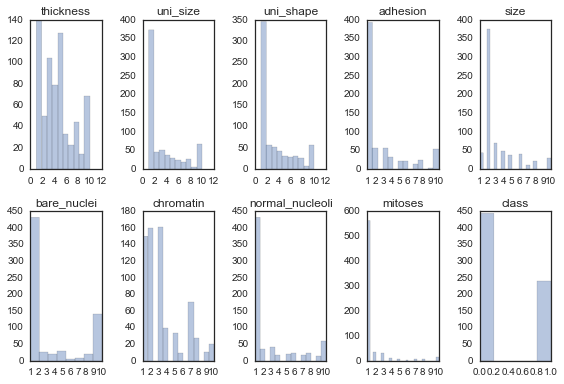

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style="white")

for col in range(1, len(data_np[0])): 
    col_name = data_np.dtype.names[col]
    data_col = data_np[col_name]
    axis = plt.subplot(2, 5, col)
    sns.distplot(data_col, kde=False)
    sns.plt.title(col_name)
plt.tight_layout()

Two things are worth noting in the above figure:
1. Most of the independent variables are heavily skewed
2. The two classes in the dependent variable are slightly imbalanced

#### 2.2 Relationship between independent variables themselves and with dependent variable

c:\python27\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


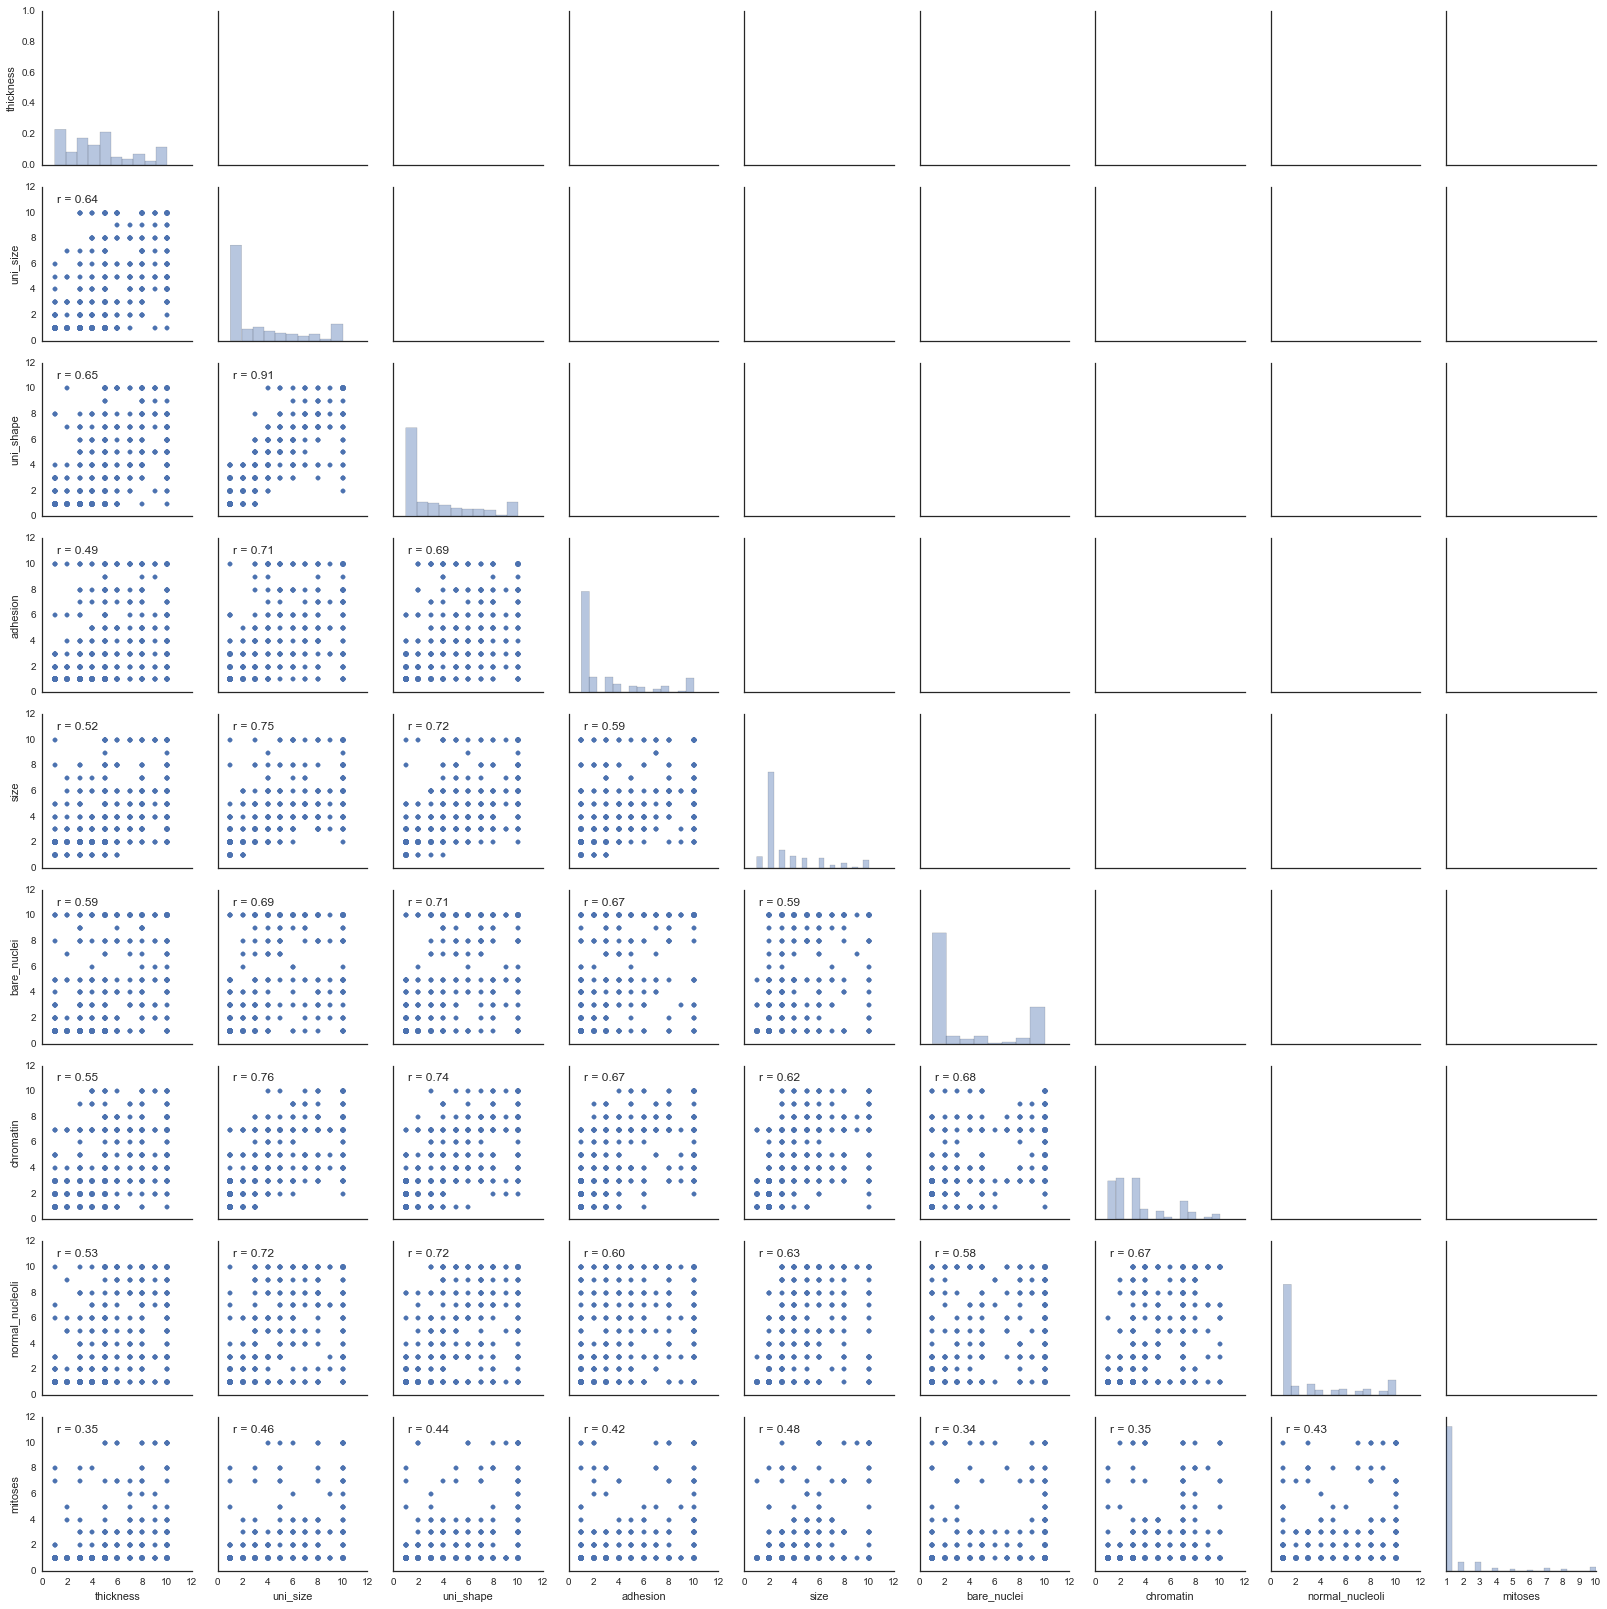

In [6]:
import pandas as pd
from scipy import stats
data_pd = pd.DataFrame(data = data_np, columns = data_np.dtype.names)

indep_vars = data_pd.ix[:, 1:10]

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(indep_vars, palette=["red"])
g.map_diag(sns.distplot, kde=False)
g.map_lower(plt.scatter, cmap="Blues_d")
g.map_lower(corrfunc)

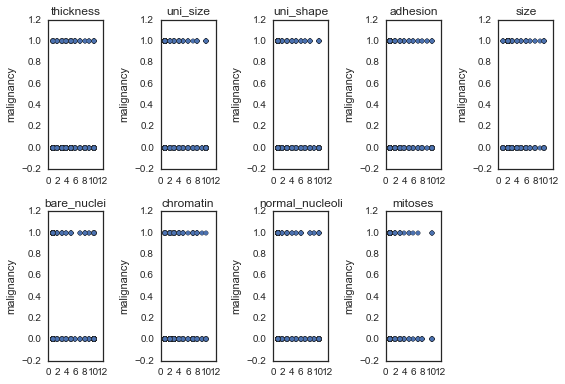

In [71]:
for i in range(9):
    indep_var = indep_vars.ix[:, i]
    plt.subplot(2, 5, i + 1)
    plt.scatter(indep_var, data_pd.ix[:, 11])
    plt.title(data_np.dtype.names[i + 1])
    plt.ylabel('malignancy')
plt.tight_layout()

The pairwise plots themselves are not super informative, due to the limitation that all independent variables are integers between 1 and 10. However, notice that all variables are positively correlated and some correlations are fairly strong (e.g., r = 0.91 for uniformity of cell size and cell shape.

Scatter plot between independent variables and dependent variable does not reveal any clear pattern either. There is no independnet variable which shows a clear cutoff for the two categories in the dependent variable.

### 3. Naive model: random forest
I first examine a naive implementation of random forest without trying to balance the classes or tweaking parameters.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

# Hold out 30% data for testing
X_train, X_test, y_train, y_test = train_test_split(indep_vars, data_pd.ix[:, 10], test_size=0.3, random_state=0)

In [12]:
clf0 = RandomForestClassifier(n_estimators = 200) # 200 trees in the forest
# 10-fold cross-validation
print "Model accuracy: ", np.mean(cross_val_score(clf0, X_train, y_train, cv = 10))
print "Model precision: ", np.mean(cross_val_score(clf0, X_train, y_train, cv = 10, scoring="precision"))
print "Model recall: ", np.mean(cross_val_score(clf0, X_train, y_train, cv = 10, scoring="recall"))

Model accuracy:  0.970646982197
Model precision:  0.960257997936
Model recall:  0.956985294118


Even without tweaking, The most naive implementation of random forest with 200 trees already has an accuracy of 0.97, precision of 0.96, and recall of 0.96. This means that about 97% of the cases are correctly predicted. 96% of those that are predicted to be malignant are truly malignant, and among all malignant cases 96% are correctly classified as malignant. 

### 4. Tweaking the model
In this section I tweak the previous random forest model in various ways to try to further improve performance.
#### 4.1 Balance classes
Interestingly, balancing the classes does not improve model performance.

In [13]:
clf1 = RandomForestClassifier(n_estimators = 200, class_weight='balanced')
# 10-fold cross-validation
print "Model accuracy: ", np.mean(cross_val_score(clf1, X_train, y_train, cv = 10))
print "Model precision: ", np.mean(cross_val_score(clf1, X_train, y_train, cv = 10, scoring="precision"))
print "Model recall: ", np.mean(cross_val_score(clf1, X_train, y_train, cv = 10, scoring="recall"))

Model accuracy:  0.970646982197
Model precision:  0.954007997936
Model recall:  0.950735294118


#### 4.2 Tuning minimal leaf size
The default minimal leaf size is set to 1, which means that there can be a single case in a leaf node. This may make the model more prone to noise in data. Here I tune the leaf size from 2 to 10 and compare model performance. 

In this example, changing the leafe size does not affect model performance.

In [18]:
for leaf in [2 * x for x in range(1, 6)]:
    print "Leaf size: ", leaf
    clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = leaf)
    print "Accuracy, precision, recall: ", np.mean(cross_val_score(clf, X_train, y_train, cv = 10)), \
    np.mean(cross_val_score(clf, X_train, y_train, cv = 10, scoring="precision")), \
    np.mean(cross_val_score(clf, X_train, y_train, cv = 10, scoring="recall"))

Leaf size:  2
Accuracy, precision, recall:  0.970646982197 0.960257997936 0.956985294118
Leaf size:  4
Accuracy, precision, recall:  0.974902301346 0.954375644995 0.969485294118
Leaf size:  6
Accuracy, precision, recall:  0.972774641772 0.960674664603 0.963235294118
Leaf size:  8
Accuracy, precision, recall:  0.974902301346 0.961042311662 0.963602941176
Leaf size:  10
Accuracy, precision, recall:  0.972774641772 0.954007997936 0.969485294118


#### 4.4 Alternative criterion, and tuning number of trees
Changing criterion from default Gini impurity to enformation gain, boosting the number of tress from 200 to 500, or set out-of-bag score to True does not change model performance.

In [19]:
clf4 = RandomForestClassifier(n_estimators = 200, criterion = 'entropy')
print "Change splitting criterion from Gini to Entropy."
print "Accuracy, precision, recall: ", np.mean(cross_val_score(clf4, X_train, y_train, cv = 10)), \
np.mean(cross_val_score(clf4, X_train, y_train, cv = 10, scoring="precision")), \
np.mean(cross_val_score(clf4, X_train, y_train, cv = 10, scoring="recall"))

Change splitting criterion from Gini to Entropy.
Accuracy, precision, recall:  0.970646982197 0.960257997936 0.956985294118


In [20]:
clf5 = RandomForestClassifier(n_estimators = 500)
print "Boost number of trees to 500."
print "Accuracy, precision, recall: ", np.mean(cross_val_score(clf5, X_train, y_train, cv = 10)), \
np.mean(cross_val_score(clf5, X_train, y_train, cv = 10, scoring="precision")), \
np.mean(cross_val_score(clf5, X_train, y_train, cv = 10, scoring="recall"))

Boost number of trees to 500.
Accuracy, precision, recall:  0.972774641772 0.960257997936 0.956985294118


In [21]:
clf6 = RandomForestClassifier(n_estimators = 200, oob_score = True)
print "Use out of bag sample to evaluate."
print "Accuracy, precision, recall: ", np.mean(cross_val_score(clf6, X_train, y_train, cv = 10)), \
np.mean(cross_val_score(clf6, X_train, y_train, cv = 10, scoring="precision")), \
np.mean(cross_val_score(clf6, X_train, y_train, cv = 10, scoring="recall"))

Use out of bag sample to evaluate.
Accuracy, precision, recall:  0.970646982197 0.960257997936 0.956985294118


Because the naive implementation of random forest already has great performance which further tuning does not significantly improve, I accept the initial model clf0 to make prediction for this data set.

### 6. Test model performance on test data
Finally, model performance should be tested using data that the model has not "seen" before.

Model metrics using test data
Accuracy:  0.951219512195
Precision:  0.945205479452
Recall:  0.92


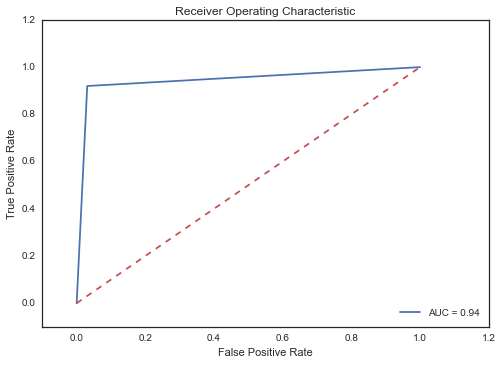

In [32]:
clf0.fit(X_train, y_train)
y_pred = clf0.predict(X_test)
print "Model metrics using test data"
print "Accuracy: ", metrics.accuracy_score(y_test.values, y_pred)
print "Precision: ", metrics.precision_score(y_test.values, y_pred)
print "Recall: ", metrics.recall_score(y_test.values, y_pred)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test.values, y_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')